<center><font face='Georgia'> 

# Natural Language Processing. 

    
<center><font size=5 color ='blue' > <i><b>Project<b></i> : Sentiment analysis on Clothes Reviews  </center></font> 
<img src="http://cdn.shopify.com/s/files/1/0162/2116/articles/How_to_Write_Reviews_on_Clothes_and_Fashion_1200x1200.jpg?v=1578809219"   
     jsaction="load:XAeZkd;" jsname="HiaYvf" class="n3VNCb KAlRDb" alt="L'oiseau Twitter tente le rebond - artsixMic" data-noaft="1" id="imi" data-w="600" data-h="487" style="width: 219px; height: 177.755px; margin: 21.5225px 0px;"> 
Binome
<font color ='red'>    
 1.TOUATI Islem.  
 2.OUCHENE Souhil.
</font>

## Importation des packages et modules :

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
sns.set()

import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud , STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score , confusion_matrix

## Importation des donnees :

In [6]:
data = pd.read_csv('Reviews.csv')
data.head()

,Age,Review Text,Division Name,Class Name,label
0,60,I had such high hopes for this dress and reall...,General,Dresses,1
1,50,"I love, love, love this jumpsuit. it's fun, fl...",General Petite,Pants,2
2,47,This shirt is very flattering to all due to th...,General,Blouses,2
3,49,"I love tracy reese dresses, but this one is no...",General,Dresses,0
4,39,I aded this in my basket at hte last mintue to...,General Petite,Knits,2


Pour faciliter notre etude, on va que faire un <strong> cleaning </strong> sur la variable Review Text .

## Du plus sur les donnees :
On va essayer d'avoir une idee generale sur notre dataframe(shape, valeurs nulles, valeurs dupliquees, mesures statistiques...)

In [7]:
data.isnull().sum()

Age              0
Review Text      0
Division Name    0
Class Name       0
label            0
dtype: int64

In [8]:
data.describe(include = 'all')

,Age,Review Text,Division Name,Class Name,label
count,19662.000000,19662,19662,19662,19662.000000
unique,NaN,19656,3,20,NaN
top,NaN,Perfect fit and i've gotten so many compliment...,General,Dresses,NaN
freq,NaN,3,11664,5371,NaN
mean,43.260808,NaN,NaN,NaN,1.666056
std,12.258122,NaN,NaN,NaN,0.656561
min,18.000000,NaN,NaN,NaN,0.000000
25%,34.000000,NaN,NaN,NaN,2.000000
50%,41.000000,NaN,NaN,NaN,2.000000
75%,52.000000,NaN,NaN,NaN,2.000000


In [9]:
data.dtypes

Age               int64
Review Text      object
Division Name    object
Class Name       object
label             int64
dtype: object

## Some visualizations : 
On veut savoir le cardinal de chaque classe de la colonne (Division name), et puis le tracer :

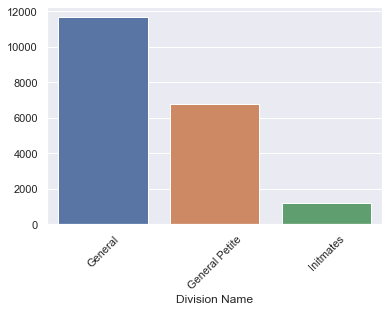

In [10]:
my_plot=sns.countplot(x='Division Name', data=data)
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
plt.ylabel('')
plt.show()

Maintenant, on veut avoir une idee sur les produits qu'on a :

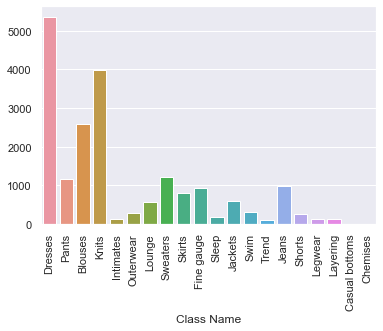

In [11]:
my_plot=sns.countplot(x='Class Name', data=data )
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=90)
plt.ylabel('')
plt.show()

On veut maintenant classer nos clients suivant des classes selon leurs ages. Pour se faire, on fait une petite analyse statistique sur les ages :

In [12]:
data['Age'].describe()

count    19662.000000
mean        43.260808
std         12.258122
min         18.000000
25%         34.000000
50%         41.000000
75%         52.000000
max         99.000000
Name: Age, dtype: float64

On va definir une fonction qui va diviser nos donnees en classes selon l'age :

In [13]:
def age_group(age):
    interval=''
    if (age<=20):
        interval="0-20"
    elif(age<40):
        interval='20-35'
    elif(age<60):
        interval='35-55'
    else:
        interval='>55'
    
        
    return interval

In [14]:
data['Age Group'] = data['Age']
data['Age Group'] = data['Age Group'].apply(age_group)

#Supprimer la colonne Age
data.drop(['Age'] , axis=1 , inplace =True)

In [18]:
# Proportion de chaque categorie d'age + pie chart :
data['Age Group'].value_counts(normalize=True)*100

20-35    44.374936
35-55    43.098362
>55      11.901129
0-20      0.625572
Name: Age Group, dtype: float64

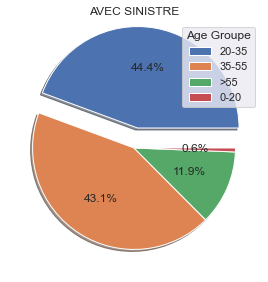

In [19]:
fig=plt.figure(figsize=(10, 10))

fig.add_subplot(1,2,1)
plt.pie(data['Age Group'].value_counts(),
        explode = [0.2, 0, 0 , 0], 
        shadow = True,
        autopct='%1.1f%%')
plt.legend(title="Age Groupe", labels=data['Age Group'].value_counts().index)
plt.title('AVEC SINISTRE')

plt.show()

## Data cleaning :
Le cleaning des donnees text brutes est une étape essentielle dans notre travail ou on essaye d'eliminer les mots et les caracteres inutiles (ponctuation, les caractères speciaux, les chiffres..), ce qui permet d'obtenir de meilleures caracteristiques.


### Removing patterns
Dans cette partie, on va essayer de supprimer tous les caracteres non alphabetiques et les remplacer avec un espace :

In [21]:
data['text_character'] = data['Review Text'].str.replace("[^a-zA-Z]", " ")

On va maintenant supprimer les mots ayant une longeur inferieure a 3:

In [22]:
data['text_character'] = data['text_character'].apply(lambda text : ' '.join([w for w in text.split() if len(w)>2]) )

On va rendre tous les caracteres alphabetiques miniscules :

In [23]:
data['text_character'] = data['text_character'].str.lower()

##### Affichage de quelques lignes avant et apres cleaning :

In [24]:
data.head(3)

,Review Text,Division Name,Class Name,label,Age Group,text_character
0,I had such high hopes for this dress and reall...,General,Dresses,1,>55,had such high hopes for this dress and really ...
1,"I love, love, love this jumpsuit. it's fun, fl...",General Petite,Pants,2,35-55,love love love this jumpsuit fun flirty and fa...
2,This shirt is very flattering to all due to th...,General,Blouses,2,35-55,this shirt very flattering all due the adjusta...


## Sentiment Analysis 

Dans cette partie, on va mesurer quelque indicateurs necessaires a notre analyse :
- La polarité qui mesure le sentiment d'un texte comme étant positif, négatif ou neutre.
- La subjectivité qui mesure le niveau de subjectivité d'un texte, qu'il soit objectif (basé sur des faits) ou subjectif (basé sur des opinions).

### Polarity and Subjectivity

In [25]:
data['Polarity'] = [ TextBlob(text).sentiment[0] for text in data['text_character']]
data['Subjectivity'] = [ TextBlob(text).sentiment[1] for text in data['text_character']]

In [26]:
data.head(3)

,Review Text,Division Name,Class Name,label,Age Group,text_character,Polarity,Subjectivity
0,I had such high hopes for this dress and reall...,General,Dresses,1,>55,had such high hopes for this dress and really ...,0.057137,0.349762
1,"I love, love, love this jumpsuit. it's fun, fl...",General Petite,Pants,2,35-55,love love love this jumpsuit fun flirty and fa...,0.500000,0.625000
2,This shirt is very flattering to all due to th...,General,Blouses,2,35-55,this shirt very flattering all due the adjusta...,0.393750,0.568750


### Sentiment intensity
On doit maintenant savoir le Sentiment Intensity qui fait référence a la force ou à l'amplitude d'un sentiment exprime dans un texte. Il s'agit d'un score allant de tres negatif à tres positif. elle fournit des informations sur une classification des sentiments (positif, négatif, neutre).

On va utiliser le modele : SentimentIntensityAnalyzer()

In [27]:
SIA = SentimentIntensityAnalyzer()

neg = [ SIA.polarity_scores(text)['neg'] for text in data['text_character']]
pos = [ SIA.polarity_scores(text)['pos'] for text in data['text_character']]
neu = [ SIA.polarity_scores(text)['neu'] for text in data['text_character']]


On rajoute ces colonnes a notre dataframe, et on affiche qulques lignes :

In [28]:
df = pd.DataFrame()
df['neg'] = neg
df['pos'] = pos
df['neu'] = neu
df.head()

,neg,pos,neu
0,0.037,0.178,0.785
1,0.246,0.452,0.302
2,0.000,0.364,0.636
3,0.000,0.175,0.825
4,0.038,0.099,0.863


On va maintenant classer nos text selon leur polarity (Negative, Neutre, Positive). Il existe plusieurs aproches pour se faire, mais on a opte pour le <strong> max </strong> . 

In [29]:
sentiment = []

for index in range(df.shape[0]):
    a = list(df.loc[index])
    m = max(a)
    i = a.index(m)
    if ( i==0) :
        sentiment.append('Negative')
    elif (i==1):
        sentiment.append('Positive')
    else :
        sentiment.append('Neutre')

On rajoute une colonne (sentiment) a notre dataframe qui represente la classification de notre message selon sa polarite, puis calculer la probabilte d'occurence de chaque classe :

In [31]:
data['sentiment'] = sentiment
data['sentiment'].value_counts(normalize = True)*100

Neutre      93.886685
Positive     6.092971
Negative     0.020344
Name: sentiment, dtype: float64

In [32]:
data.head()

,Review Text,Division Name,Class Name,label,Age Group,text_character,Polarity,Subjectivity,sentiment
0,I had such high hopes for this dress and reall...,General,Dresses,1,>55,had such high hopes for this dress and really ...,0.057137,0.349762,Neutre
1,"I love, love, love this jumpsuit. it's fun, fl...",General Petite,Pants,2,35-55,love love love this jumpsuit fun flirty and fa...,0.500000,0.625000,Positive
2,This shirt is very flattering to all due to th...,General,Blouses,2,35-55,this shirt very flattering all due the adjusta...,0.393750,0.568750,Neutre
3,"I love tracy reese dresses, but this one is no...",General,Dresses,0,35-55,love tracy reese dresses but this one not for ...,0.178750,0.533125,Neutre
4,I aded this in my basket at hte last mintue to...,General Petite,Knits,2,20-35,aded this basket hte last mintue see what woul...,0.060500,0.529333,Neutre


Pour mieux visualiser nos resultats, on utilise un pie chart qui represente les proportions de chaque classe :

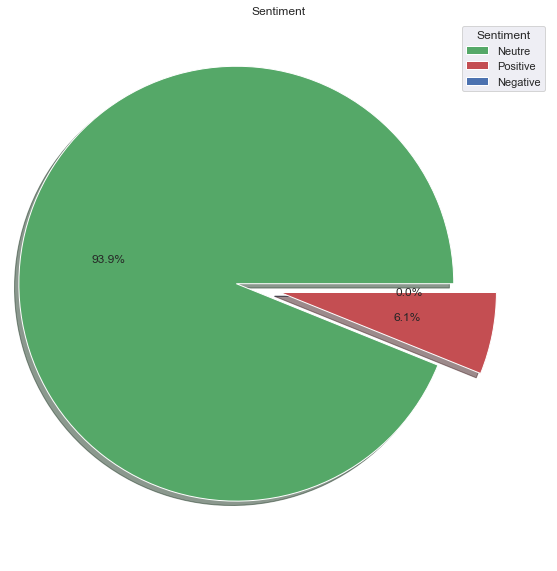

In [35]:
fig=plt.figure(figsize=(10, 10))

plt.pie(data['sentiment'].value_counts(),
        explode = [0.2, 0 ,0], 
        shadow = True,
        autopct='%1.1f%%',
        colors=['g', "r" ,"b"])
plt.legend(title="Sentiment", labels=['Neutre', 'Positive' , 'Negative'])
plt.title('Sentiment')
plt.show()

Comme on peut voir :
- la majorite des texts sont de polarite neutre.
- d'une facon moins importante, positive.
- Negative : presque nulle.

### Stemming

Stemming est un processus qui consiste à reduire les mots a leur forme de base(racine). Son objectif est de normaliser les mots a leur forme de base afin que les mots qui ont la même signification soient traites comme le meme mot : on met l'accent sur le sens des mots et non sur leur forme specifique.

Mais, on a seulement des text (phrases), alors on va d'abord les tokenizer (diviser nos phrases(text) en mots(notre cas)).

In [36]:
all_text = data['text_character'].apply(lambda x : word_tokenize(x))
all_text

0        [had, such, high, hopes, for, this, dress, and...
1        [love, love, love, this, jumpsuit, fun, flirty...
2        [this, shirt, very, flattering, all, due, the,...
3        [love, tracy, reese, dresses, but, this, one, ...
4        [aded, this, basket, hte, last, mintue, see, w...
                               ...                        
19657    [was, very, happy, snag, this, dress, such, gr...
19658    [reminds, maternity, clothes, soft, stretchy, ...
19659    [this, fit, well, but, the, top, was, very, se...
19660    [bought, this, dress, for, wedding, have, this...
19661    [this, dress, lovely, platinum, feminine, and,...
Name: text_character, Length: 19662, dtype: object

Pour le Stemming, on va utiliser PorterStemmer(), et puis on va afficher nos resultats :

In [37]:
porter = PorterStemmer() 
# stemming
stemmed_text = all_text.apply(lambda x: [porter.stem(i) for i in x]) 
stemmed_text

0        [had, such, high, hope, for, thi, dress, and, ...
1        [love, love, love, thi, jumpsuit, fun, flirti,...
2        [thi, shirt, veri, flatter, all, due, the, adj...
3        [love, traci, rees, dress, but, thi, one, not,...
4        [ade, thi, basket, hte, last, mintu, see, what...
                               ...                        
19657    [wa, veri, happi, snag, thi, dress, such, grea...
19658    [remind, matern, cloth, soft, stretchi, shini,...
19659    [thi, fit, well, but, the, top, wa, veri, see,...
19660    [bought, thi, dress, for, wed, have, thi, summ...
19661    [thi, dress, love, platinum, feminin, and, fit...
Name: text_character, Length: 19662, dtype: object

On va maintenant reconstituer nos phrases apres stemming :

In [34]:
for i in range(len(data)):
    stemmed_text[i] = ' '.join(stemmed_text[i])    
data['text_character'] = stemmed_text

In [35]:
data.head()

,Review Text,Division Name,Class Name,label,Age Group,text_character,Polarity,Subjectivity,sentiment
0,I had such high hopes for this dress and reall...,General,Dresses,1,>55,had such high hope for thi dress and realli wa...,0.057137,0.349762,Neutre
1,"I love, love, love this jumpsuit. it's fun, fl...",General Petite,Pants,2,35-55,love love love thi jumpsuit fun flirti and fab...,0.500000,0.625000,Positive
2,This shirt is very flattering to all due to th...,General,Blouses,2,35-55,thi shirt veri flatter all due the adjust fron...,0.393750,0.568750,Neutre
3,"I love tracy reese dresses, but this one is no...",General,Dresses,0,35-55,love traci rees dress but thi one not for the ...,0.178750,0.533125,Neutre
4,I aded this in my basket at hte last mintue to...,General Petite,Knits,2,20-35,ade thi basket hte last mintu see what would l...,0.060500,0.529333,Neutre


###  Quelques Visualizations :
Dans cette partie, nous allons essayer d'exploiter nos reviews, a l'aide de visualisations afin d'obtenir plus d'informations. Nous allons essayer de voir :

- Quels sont les mots les plus frequents dans nos donnees ?
- Comment sont reparties les sentiments selon les groupes d'age?
- Comment sont reparties les sentiments selon les divisions?
- Comment sont reparties les sentiments selon les produits?



On va d'abord utiliser le WordCloud pour visualiser les mots les plus fréquents dans nos texts(Taille) et le sentiment associe e chaque mot (couleurs).

On va d'abord fusionner tous nos texts en une seule liste qui sera argument du WordCloud :

In [39]:
all_words = ''.join([text for text in data['text_character']]) 

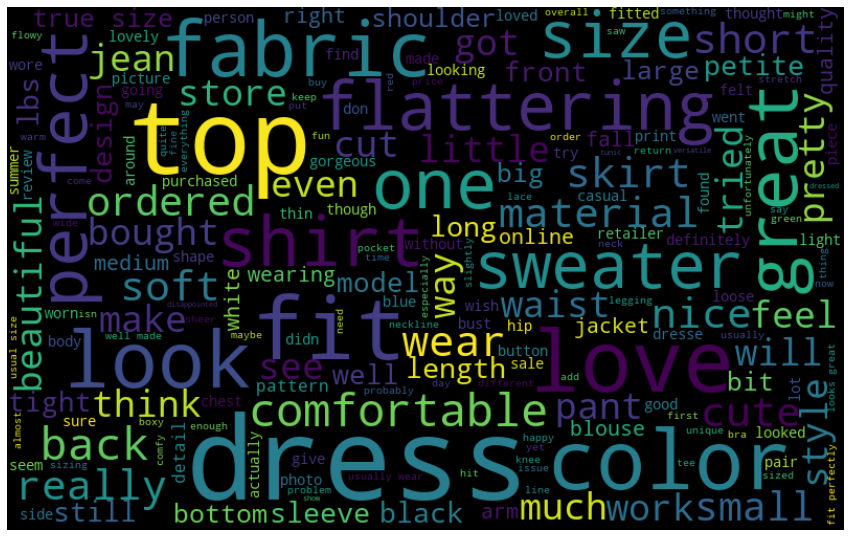

In [40]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(15, 15)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

Comme on peut voir dans cette figure, nos resultats sont confirmes, On a une majorite de neutral/positive reviews (jaune, bleu et vert) avec une abscence de mots negatifs (pas de rouge, orange ou noir),  et la taille de chaque mot represente sa frequence : Top, love, great, dress ... les plus frequents.

#### Removing StopWords
Dans cette partie, on veut se concentrer seulement sur les mots les plus significatifs et pertinents de nos donnees. Alors on va supprimer les mots qui n'ont pas une grande importance surtout pour le clothes reviews. 

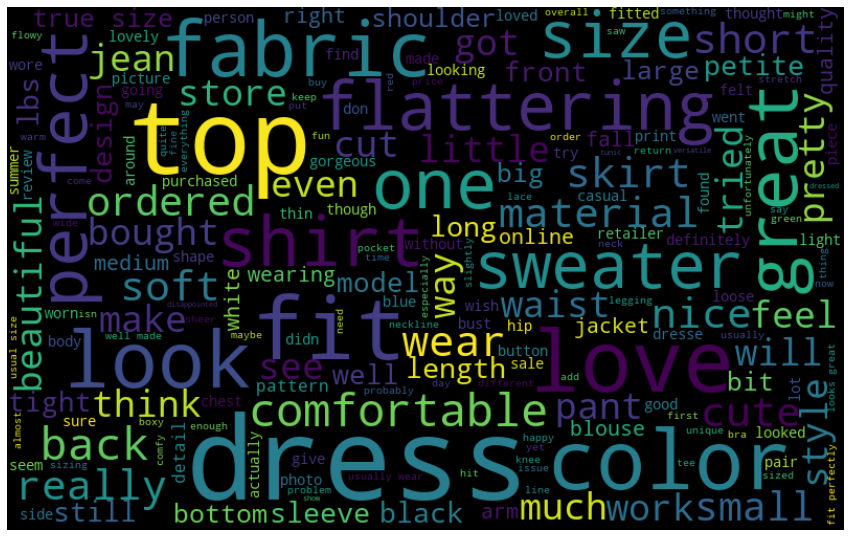

In [42]:
# liste deja predefinie :
my_stopwords = set(STOPWORDS)
my_cloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110 , stopwords=my_stopwords).generate(all_words)
plt.figure(figsize=(15, 15)) 
plt.imshow(my_cloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

Maintenant on veut savoir la repartition de chaque groupe d'age selon leurs sentiment:

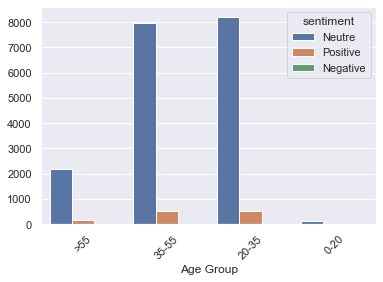

In [39]:
my_plot=sns.countplot(x='Age Group', hue='sentiment', data=data)
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
plt.ylabel('')
plt.show()

On peut remarquer que :
- Les groupes d'ages les plus contribuants sont (30-55 et 20-35) et leurs taux de neutralite est presque similaire.
- Ces 2 groupes ont aussi un taux de reviews positif similaire


Maintenant on veut savoir la repartition de chaque divisionselon leurs sentiment:

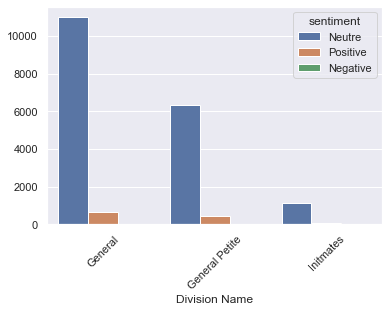

In [43]:
my_plot=sns.countplot(x='Division Name', hue='sentiment', data=data)
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
plt.ylabel('')
plt.show()

- La plupart des avis sont neutres ou positifs. Le "general" contient un taux positif plus élevé que le "General Petite" et "Initmates".

Maintenant on veut savoir les sentiments des clients selon chaque produit :

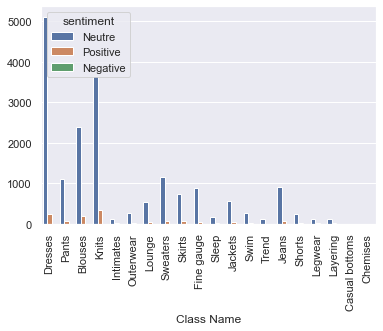

In [44]:
my_plot=sns.countplot(x='Class Name', hue='sentiment', data=data)
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=90)
plt.ylabel('')
plt.show()

- les produits (Dresses, krits et Blouses) sont les plus ayant des reviews (Neutres aussi).

### Some Machine Learning :
Le but de notre etude est d'essayer de predire le sentiment a partir d'un nouveau text comme entree, c'est pour cela on va generer plusieurs modeles(Regresion logistique, XGB) a l'aide de differentes methodes pour vectorisation(Bag-Of-Words, TF-IDF)


On doit d'abord choisir les colonnes avec lesquelles on va continuer notre travail :
- text_character : le text qu'on a deja traite.
- label : c'est le sentiment, (0 : negatif),(1 : neutre) et (2 : positif)

In [48]:
data = data[['text_character' , 'label']]
data

,text_character,label
0,had such high hopes for this dress and really ...,1
1,love love love this jumpsuit fun flirty and fa...,2
2,this shirt very flattering all due the adjusta...,2
3,love tracy reese dresses but this one not for ...,0
4,aded this basket hte last mintue see what woul...,2
...,...,...
19657,was very happy snag this dress such great pric...,2
19658,reminds maternity clothes soft stretchy shiny ...,1
19659,this fit well but the top was very see through...,1
19660,bought this dress for wedding have this summer...,1


# Vectorization : 
La vectorisation de texte est le processus de conversion de donnees textuelles en vecteurs ou matrices numeriques qui peuvent etre utilises comme entrees pour les algorithmes du ML. Cette operation est necessaire car la plupart des algorithmes d'apprentissage automatique ne peuvent pas travailler directement avec des donnees textuelles et ont besoin de representations numeriques. Elle peut être réalisée à l'aide de différentes techniques :
- Le Bag-of-Words (BoW)
- term frequency-inverse document frequency (TF-IDF)

## Bag-Of-Words features (BOW)
Le Bag-of-Words (BoW) est une méthode permettant de représenter un texte sous forme de vecteur numérique en comptant la fréquence des mots (ou "tokens") dans un document. Le vecteur résultant représente la présence et la fréquence des mots dans un document.

In [50]:
vect = CountVectorizer(max_df = 0.90, min_df = 2, max_features = 1000, stop_words='english') 
X = vect.fit_transform(data['text_character'])
X.shape

(19662, 1000)

## Affichage apres vectorisation :

In [68]:
my_array = X.toarray()
X_df = pd.DataFrame(my_array , columns = vect.get_feature_names())
X_df.head()

,able,absolutely,actually,add,added,addition,adds,adjustable,adorable,adore,...,xsp,xxs,xxsp,year,years,yellow,yes,yesterday,zip,zipper
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Spliting our data to train & test  sets :

In [52]:
X_train , X_test , Y_train , Y_test = train_test_split(X , data['label'] , test_size =0.2 , random_state = 45)

Commencons par le modele de regression logistique : 

### Logistic regression

In [54]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train , Y_train)
Y_predict = logistic_model.predict(X_test)

C:\Users\Computer House\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La precision du modele : 

In [55]:
print('Accuracy score on test data: ', accuracy_score(Y_test, Y_predict))

Accuracy score on test data:  0.8108314263920672


La matrice de Confusion :

In [56]:
matrix_log = confusion_matrix(Y_test, Y_predict)
matrix_log

array([[ 191,   93,  125],
       [ 103,  130,  245],
       [  51,  127, 2868]], dtype=int64)

Un affichage plus propre :

In [57]:
cm_df = pd.DataFrame(matrix_log)
cm_df.columns = ['Predicted 0','Predicted 1','Predicted 2']
cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1',2:'Actual 2'})
cm_df

,Predicted 0,Predicted 1,Predicted 2
Actual 0,191,93,125
Actual 1,103,130,245
Actual 2,51,127,2868


Le 2eme modele est XGB :

###  modele XGB 

In [58]:
XGB_model = XGBClassifier(n_estimators=1000)
XGB_model.fit(X_train , Y_train)
Y_pred_XGB =XGB_model.predict(X_test)

La precision du modele : 

In [59]:
print('Accuracy score on test data: ', accuracy_score(Y_test, Y_pred_XGB))

Accuracy score on test data:  0.8082888380371218


In [62]:
matrix_XGB = confusion_matrix(Y_test, Y_pred_XGB)
matrix_XGB

array([[ 168,  109,  132],
       [  97,  117,  264],
       [  39,  113, 2894]], dtype=int64)

In [63]:
cm_df_XGB = pd.DataFrame(matrix_XGB)
cm_df_XGB.columns = ['Predicted 0','Predicted 1','Predicted 2']
cm_df_XGB = cm_df_XGB.rename(index={0: 'Actual 0',1:'Actual 1',2:'Actual 2'})
cm_df_XGB

,Predicted 0,Predicted 1,Predicted 2
Actual 0,168,109,132
Actual 1,97,117,264
Actual 2,39,113,2894


## TF-IDF

L'indice BoW est une représentation simple mais efficace qui peut être améliorée en ajoutant des fonctionnalités telles que la fréquence des termes dans l'inverse de la fréquence des documents (TF-IDF) pour pondérer davantage les mots plus rares.

TF-IDF est une statistique numérique qui reflète l'importance d'un mot pour un document dans une collection ou un corpus. Elle est le produit de deux métriques : la fréquence des termes (TF) et la fréquence inverse des documents (IDF). TF mesure la fréquence d'un mot dans un document, tandis que IDF mesure la rareté du mot dans tous les documents. Plus la valeur TF-IDF est élevée, plus le mot est important dans le document. Elle est utilisée pour les tâches de recherche d'informations et d'exploration de textes, telles que la classification de textes, le regroupement de textes et les comparaisons de similarité de documents.

In [74]:
vect_tf = TfidfVectorizer(max_df = 0.90, min_df = 2, max_features = 1000, stop_words='english') 
X_tf = vect_tf.fit_transform(data['text_character'])
X_tf.shape

(19662, 1000)

## Affichage apres vectorisation :

In [76]:
my_array = X_tf.toarray()
X_df_tf= pd.DataFrame(my_array , columns = vect_tf.get_feature_names())
X_df_tf.head()

,able,absolutely,actually,add,added,addition,adds,adjustable,adorable,adore,...,xsp,xxs,xxsp,year,years,yellow,yes,yesterday,zip,zipper
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.20508,0.179638
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.396011,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000


## Spliting our data to train & test  sets :

In [77]:
X_train , X_test , Y_train , Y_test = train_test_split(X_tf , data['label'] , test_size =0.2 , random_state = 45)

Commencons par le modele de regression logistique : 

### Logistic regression

In [78]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train , Y_train)
Y_predict = logistic_model.predict(X_test)

C:\Users\Computer House\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


La precision du modele : 

In [79]:
print('Accuracy score on test data: ', accuracy_score(Y_test, Y_predict))

Accuracy score on test data:  0.8161708619374524


Matrice de Confusion :

In [81]:
matrix_log = confusion_matrix(Y_test, Y_predict)
matrix_log

array([[ 163,   95,  151],
       [  90,  106,  282],
       [  25,   80, 2941]], dtype=int64)

Affichage propre :

In [82]:
cm_df_log = pd.DataFrame(matrix_log)
cm_df_log.columns = ['Predicted 0','Predicted 1','Predicted 2']
cm_df_log = cm_df_log.rename(index={0: 'Actual 0',1:'Actual 1',2:'Actual 2'})
cm_df_log

,Predicted 0,Predicted 1,Predicted 2
Actual 0,163,95,151
Actual 1,90,106,282
Actual 2,25,80,2941


####  modèle XGB 

In [57]:
XGB_model = XGBClassifier(n_estimators=1000)
XGB_model.fit(X_train , Y_train)
Y_pred_XGB =XGB_model.predict(X_test)

La precision du modele : 

In [58]:
print('Accuracy score on test data: ', accuracy_score(Y_test, Y_pred_XGB))

Accuracy score on test data:  0.8143910500889906


Matrice de Confusion :

In [59]:
matrix_XGB_tf = confusion_matrix(Y_test, Y_pred_XGB)
matrix_XGB_tf

array([[ 173,   95,  141],
       [ 100,  122,  256],
       [  41,   97, 2908]], dtype=int64)

Affichage propre :

In [60]:
cm_df_XGB_tf = pd.DataFrame(matrix_XGB)
cm_df_XGB_tf.columns = ['Predicted 0','Predicted 1','Predicted 2']
cm_df_XGB_tf = cm_df_XGB_tf.rename(index={0: 'Actual 0',1:'Actual 1',2:'Actual 2'})
cm_df_XGB_tf

,Predicted 0,Predicted 1,Predicted 2
Actual 0,173,95,141
Actual 1,100,122,256
Actual 2,41,97,2908


## Conclusion :

Le meilleur modele(en performance) est celui de la regression logistique apres une vectorisation TF-IDF avec un score de precision de 81.6%